# Exploring the NIH Chest X-ray Dataset

In this notebook, we aim to gain a deeper understanding of the NIH Chest X-ray dataset by performing various analyses. We'll explore disease distributions, analyze patient age demographics, and visualize the relationships between different variables.


## 1. Importing Libraries

In [9]:
import os
import math
import ast
from collections import defaultdict

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler

# Set Seaborn theme for all plots
sns.set_theme(style="whitegrid")

## 2. Data Loading and Preprocessing

In this section, we'll load the dataset, perform necessary preprocessing steps such as handling missing values, cleaning column names, and transforming data types to prepare for analysis.

In [10]:
# Define file paths
bbox_file = './dataset/BBox_List_2017.csv'
data_entry_file = './dataset/Data_Entry_2017.csv'

# Load datasets
bbox_df = pd.read_csv(bbox_file)
data_entry_df = pd.read_csv(data_entry_file)

# Display basic information about the datasets
print("BBox DataFrame Shape:", bbox_df.shape)
print("Data Entry DataFrame Shape:", data_entry_df.shape)
data_entry_df.head()

BBox DataFrame Shape: (984, 9)
Data Entry DataFrame Shape: (112120, 12)


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


### 2.1. Cleaning the Data Entry DataFrame

- **Convert Columns to Supported Types:** Ensure that all columns have types compatible with downstream processing.
- **Remove Unnecessary Columns:** Drop any columns that are unnamed or irrelevant.
- **Transform 'Finding Labels':** Split the 'Finding Labels' column into lists for easier analysis.


In [11]:
# Convert 'Finding Labels' to string type to ensure compatibility
data_entry_df['Finding Labels'] = data_entry_df['Finding Labels'].astype(str)

# Remove columns that have "Unnamed" in their names (often result from saving DataFrames)
data_entry_df = data_entry_df.loc[:, ~data_entry_df.columns.str.contains('^Unnamed')]

# Split the 'Finding Labels' column into lists of individual labels
data_entry_df['Finding Labels'] = data_entry_df['Finding Labels'].str.split('|')

# Display the cleaned DataFrame
data_entry_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
0,00000001_000.png,[Cardiomegaly],0,1,58,M,PA,2682,2749,0.143,0.143
1,00000001_001.png,"[Cardiomegaly, Emphysema]",1,1,58,M,PA,2894,2729,0.143,0.143
2,00000001_002.png,"[Cardiomegaly, Effusion]",2,1,58,M,PA,2500,2048,0.168,0.168
3,00000002_000.png,[No Finding],0,2,81,M,PA,2500,2048,0.171,0.171
4,00000003_000.png,[Hernia],0,3,81,F,PA,2582,2991,0.143,0.143


## 3. Distribution of Diseases

In this section, we'll analyze the distribution of various diseases present in the dataset. We'll create a function that visualizes both the absolute counts and the relative probabilities of each disease, facilitating a comprehensive understanding of disease prevalence.


/tmp/ipykernel_510653/2354423029.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_510653/2354423029.py:62: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_510653/2354423029.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_510653/2354423029.py:101: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')


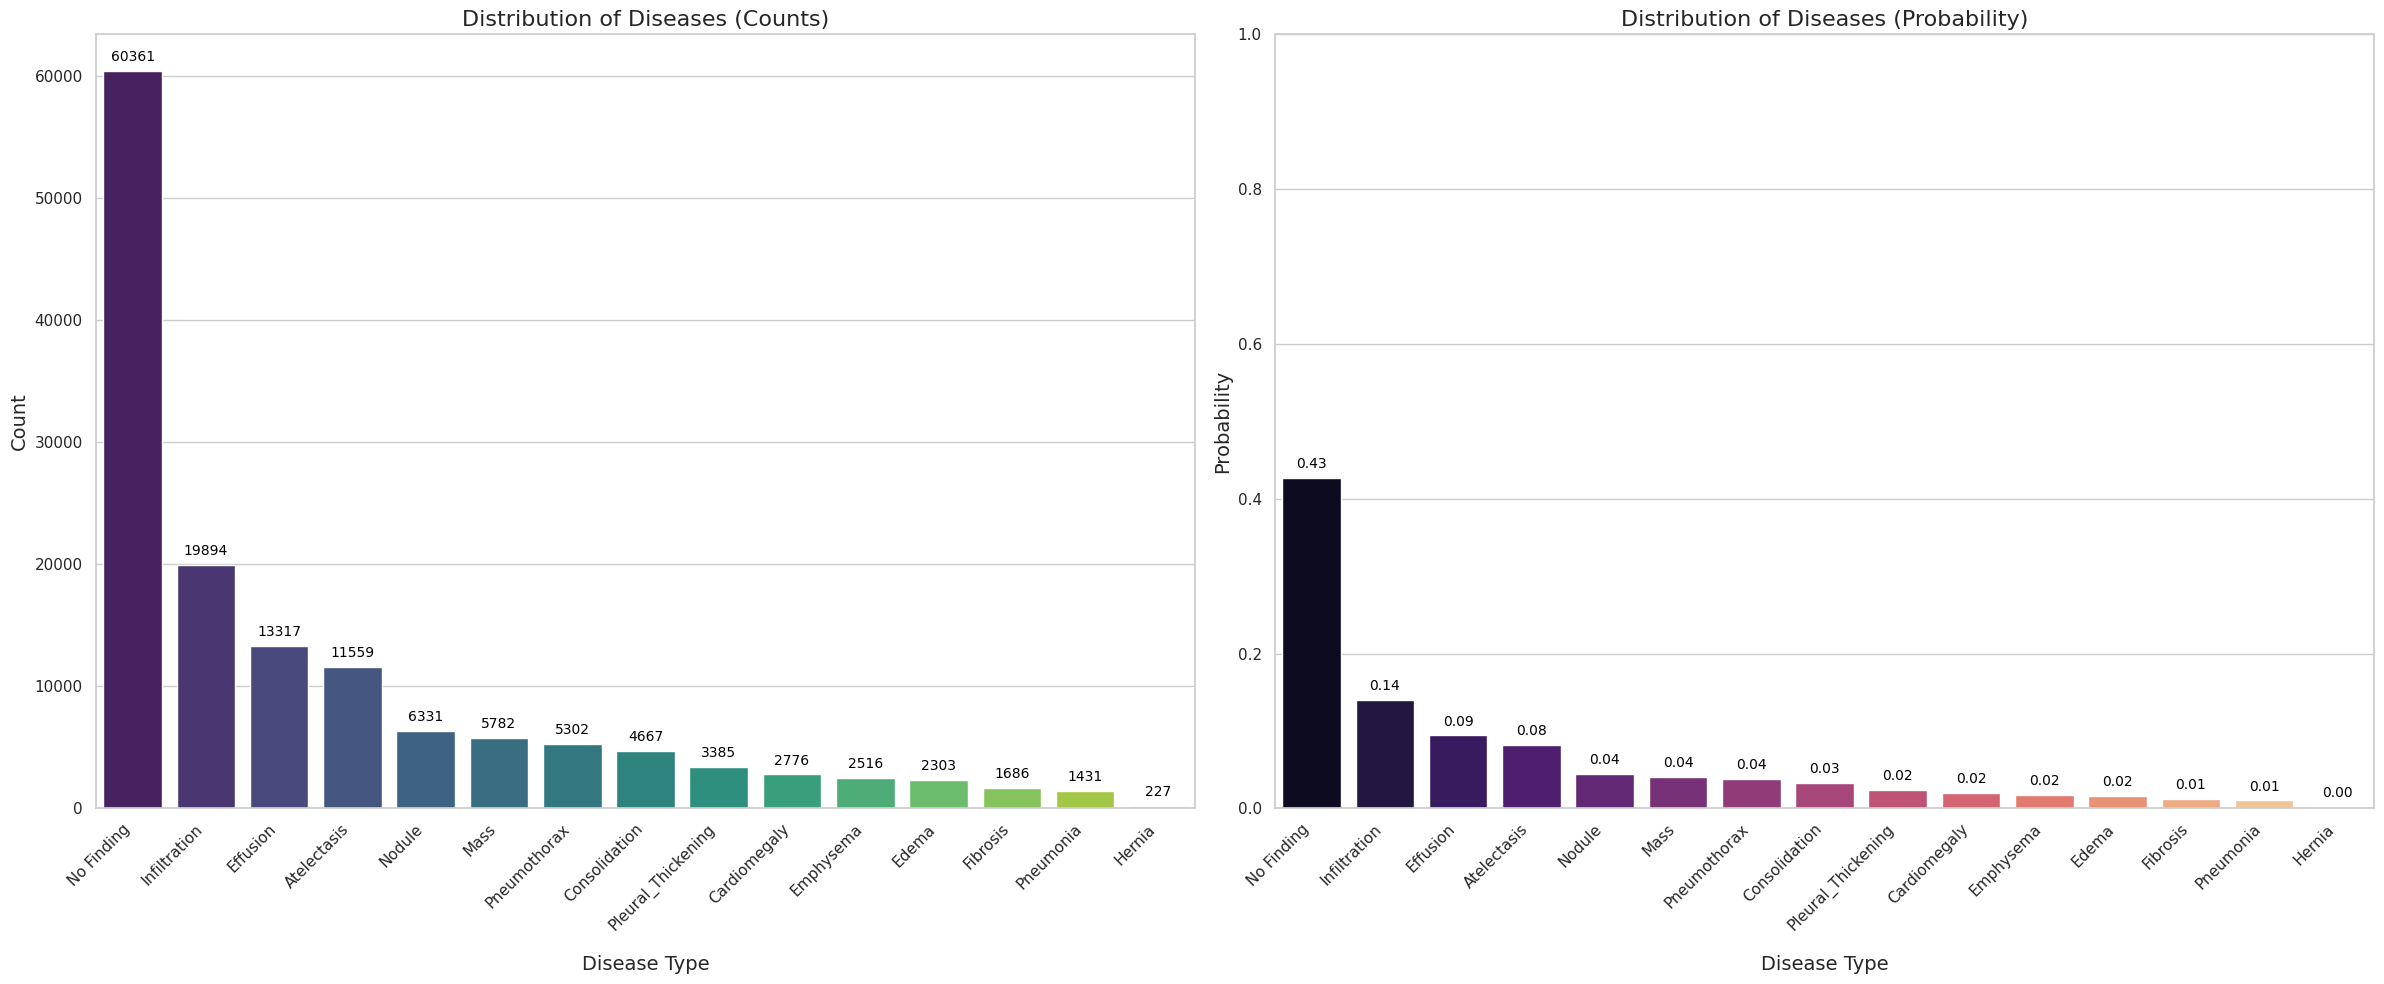

In [22]:
def plot_column_distribution(df, column, threshold=10):
    """
    Plots the distribution of categories within a specified column of a DataFrame.
    
    Generates a figure with two subplots:
    - Left: Bar plot of disease counts exceeding the threshold.
    - Right: Bar plot of disease probabilities (relative frequencies).
    
    Parameters:
    - df (pd.DataFrame): The DataFrame containing the data.
    - column (str): The column name to analyze.
    - threshold (int): Minimum count required to display a category.
    """
    # Explode the column to separate multiple labels into individual rows
    all_labels = df[column].explode()
    
    # Count occurrences of each disease
    disease_counts = all_labels.value_counts().sort_values(ascending=False)
    
    # Filter out diseases below the threshold
    disease_counts = disease_counts[disease_counts > threshold]
    
    # Calculate probabilities (relative frequencies) for each disease
    disease_probabilities = disease_counts / disease_counts.sum()
    
    # Initialize the figure with two subplots side by side
    fig, axes = plt.subplots(1, 2, figsize=(24, 10))
    
    # --------------------------- #
    # Left Subplot: Disease Counts
    # --------------------------- #
    ax1 = axes[0]
    
    # Create a bar plot for disease counts
    sns.barplot(
        x=disease_counts.index, 
        y=disease_counts.values, 
        palette="viridis", 
        dodge=False, 
        ax=ax1
    )
    
    # Annotate each bar with its count
    for p in ax1.patches:
        ax1.annotate(
            f'{int(p.get_height())}', 
            (p.get_x() + p.get_width() / 2., p.get_height()), 
            ha='center', 
            va='center', 
            xytext=(0, 10), 
            textcoords='offset points',
            fontsize=10,
            color='black'
        )
    
    # Set plot labels and title for the left subplot
    ax1.set_xlabel('Disease Type', fontsize=14, labelpad=15)
    ax1.set_ylabel('Count', fontsize=14)
    ax1.set_title('Distribution of Diseases (Counts)', fontsize=16)
    
    # Rotate x-axis labels for better readability
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
    
    # --------------------------- #
    # Right Subplot: Disease Probabilities
    # --------------------------- #
    ax2 = axes[1]
    
    # Create a bar plot for disease probabilities
    sns.barplot(
        x=disease_probabilities.index, 
        y=disease_probabilities.values, 
        palette="magma", 
        dodge=False, 
        ax=ax2
    )
    
    # Annotate each bar with its probability
    for p in ax2.patches:
        probability = p.get_height()
        ax2.annotate(
            f'{probability:.2f}', 
            (p.get_x() + p.get_width() / 2., p.get_height()), 
            ha='center', 
            va='center', 
            xytext=(0, 10), 
            textcoords='offset points',
            fontsize=10,
            color='black'
        )
    
    # Set plot labels and title for the right subplot
    ax2.set_xlabel('Disease Type', fontsize=14, labelpad=15)
    ax2.set_ylabel('Probability', fontsize=14)
    ax2.set_title('Distribution of Diseases (Probability)', fontsize=16)
    
    # Set y-axis limits from 0 to 1 for probability
    ax2.set_ylim(0, 1)
    
    # Rotate x-axis labels for better readability
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')
    
    # Adjust layout for better spacing and display the plots
    plt.tight_layout()
    plt.show()

# %%
# Plot the distribution with a threshold of 100 to focus on prevalent diseases
plot_column_distribution(data_entry_df, 'Finding Labels', threshold=100)

## 4. Disease Distribution Across Age Groups

This section analyzes how different diseases are distributed across various patient age groups. We'll categorize ages into bins and visualize the prevalence of each disease within these age ranges.


In [16]:
# Define age bins and corresponding labels
age_bins = list(range(0, 110, 10))  # [0, 10, 20, ..., 100]
age_labels = [f'{i}-{i+10}' for i in age_bins[:-1]]

# Extract all unique diseases from the dataset
diseases = sorted({disease for sublist in data_entry_df['Finding Labels'] for disease in sublist})

# Initialize a DataFrame to hold disease counts per age group
disease_count_matrix = pd.DataFrame(0, index=age_labels, columns=diseases)

# Populate the count matrix
for i in range(1, len(age_bins)):
    # Define the current age range
    lower_bound = age_bins[i-1]
    upper_bound = age_bins[i]
    
    # Filter patients within the current age range (inclusive of the upper bound)
    age_range_df = data_entry_df[data_entry_df['Patient Age'].between(lower_bound, upper_bound, inclusive="right")]
    
    # Count occurrences of each disease within this age range
    bin_disease_count = age_range_df['Finding Labels'].explode().value_counts().reindex(diseases, fill_value=0)
    
    # Assign the counts to the matrix
    disease_count_matrix.loc[age_labels[i-1]] = bin_disease_count

# Display the disease count matrix
disease_count_matrix.head()

,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0-10,132,45,132,31,131,10,4,0,429,53,1072,44,35,41,44
10-20,382,147,247,127,505,171,38,1,1103,255,3513,227,149,95,425
20-30,977,342,552,294,1352,261,118,4,2649,660,7684,614,308,200,685
30-40,1314,427,689,415,1683,251,180,3,2921,738,9735,762,416,247,678
40-50,2288,498,836,418,2428,350,354,23,3835,1064,12332,1287,533,250,1015


### 4.1. Normalizing and Visualizing the Disease Distribution

We'll normalize the disease counts to understand the relative prevalence across age groups and visualize this using a heatmap.


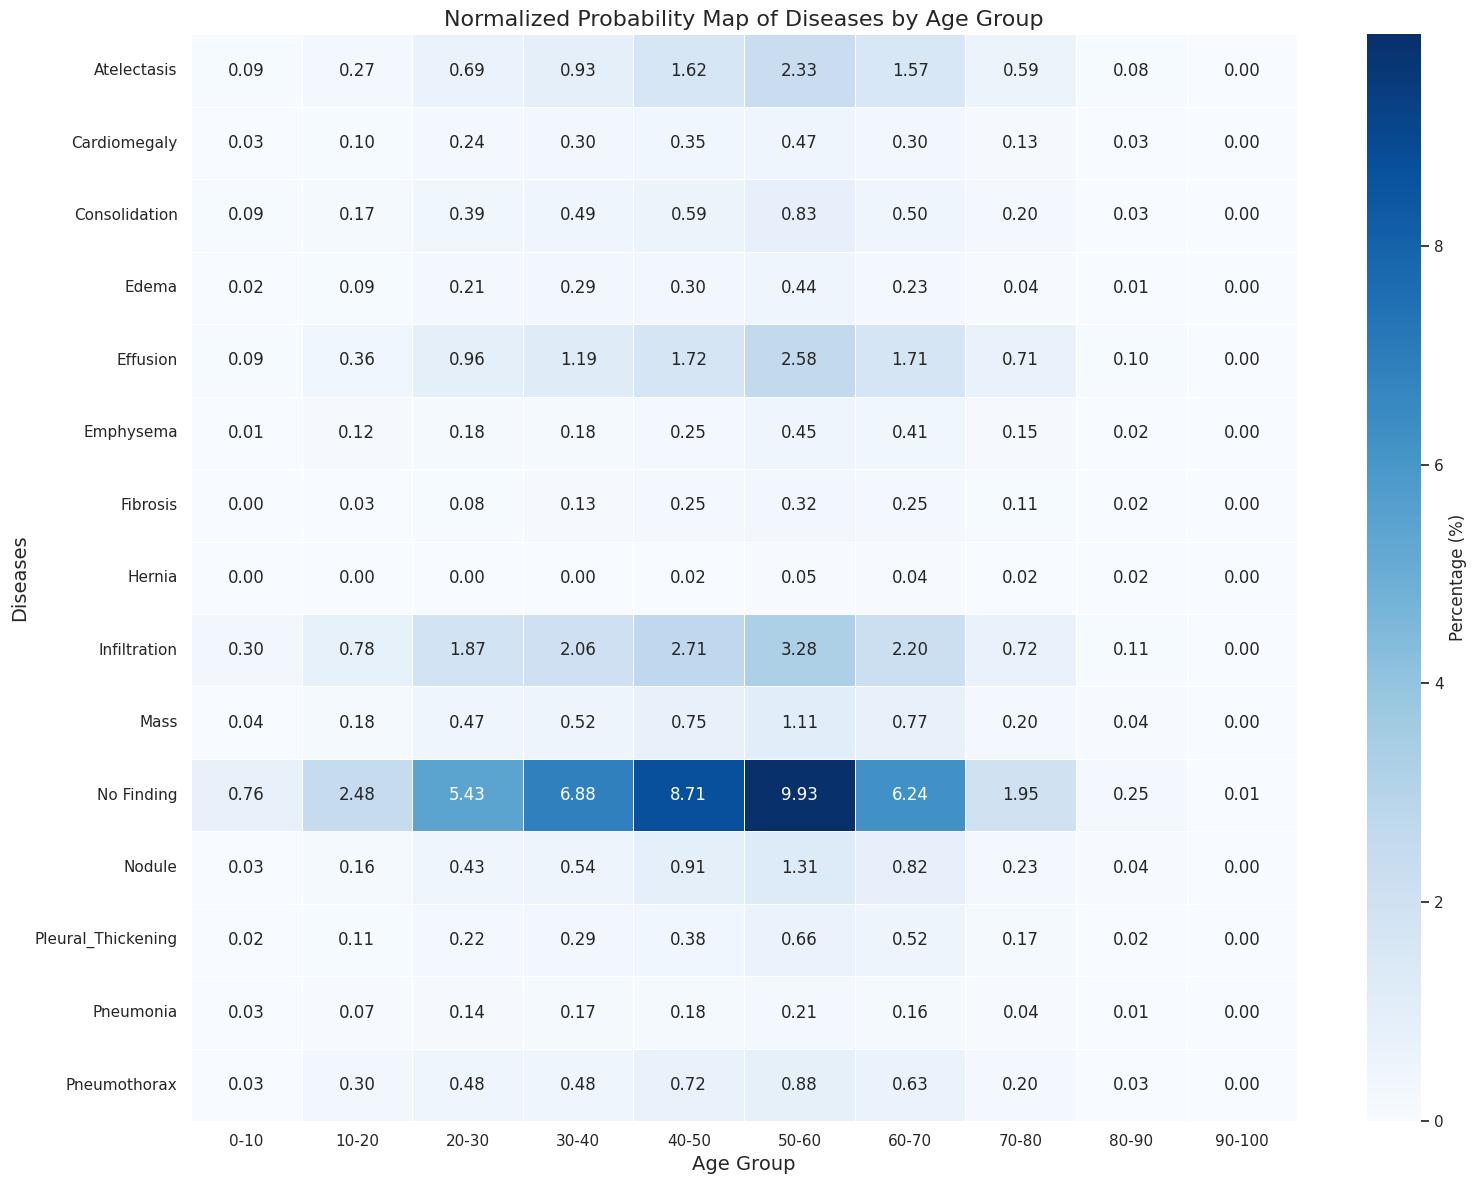

In [18]:
# Normalize the count matrix globally to get percentages
normalized_map = disease_count_matrix / disease_count_matrix.values.sum() * 100

# Initialize the plot
plt.figure(figsize=(16, 12))

# Create a heatmap of the normalized disease distribution
sns.heatmap(
    normalized_map.T, 
    annot=True, 
    cmap='Blues', 
    fmt=".2f", 
    linewidths=.5, 
    cbar_kws={'label': 'Percentage (%)'}
)

# Set plot labels and title
plt.title('Normalized Probability Map of Diseases by Age Group', fontsize=16)
plt.xlabel('Age Group', fontsize=14)
plt.ylabel('Diseases', fontsize=14)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

## 5. Analyzing Patient Age Distribution

Understanding the age distribution of patients is crucial for identifying demographic trends. We'll compute and visualize both the Cumulative Distribution Function (CDF) and the Probability Density Function (PDF) of patient ages.


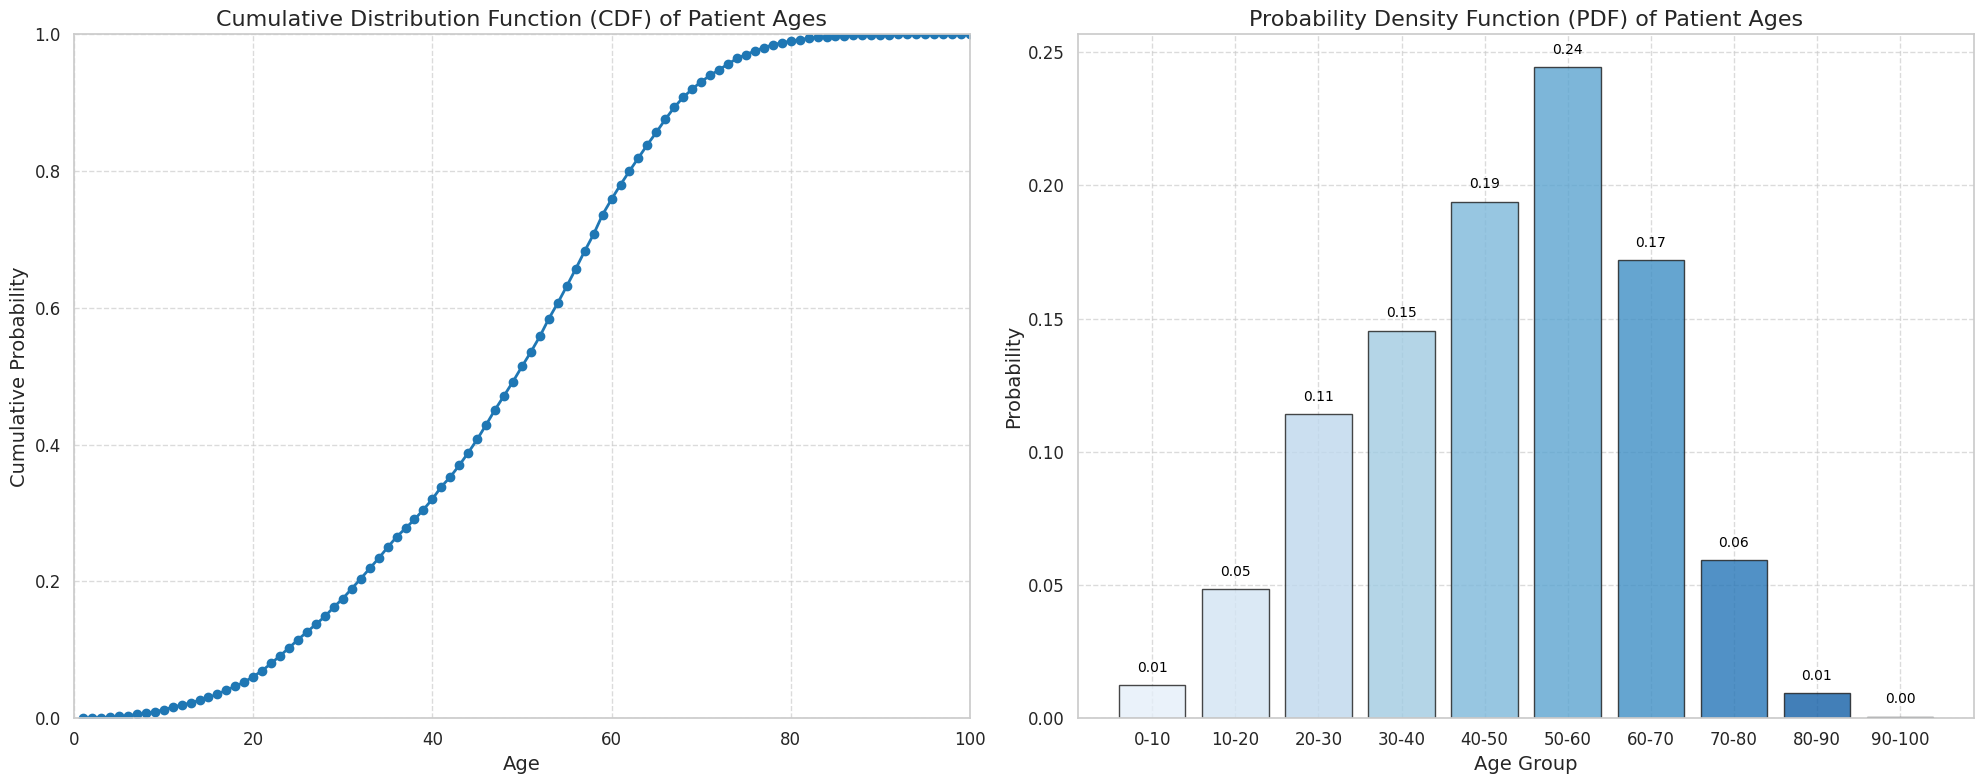

In [19]:
# Extract the 'Patient Age' column and drop missing values
ages = data_entry_df['Patient Age'].dropna()

# Define age bins and labels (reuse from previous section)
age_bins = list(range(0, 110, 10))  # [0, 10, 20, ..., 100]
age_labels = [f'{i}-{i+10}' for i in age_bins[:-1]]

# Calculate the histogram for CDF
counts, bin_edges = np.histogram(ages, bins=100, range=(0, 100), density=True)
cdf = np.cumsum(counts) * (bin_edges[1] - bin_edges[0])

# Calculate the histogram for PDF across defined age bins
pdf_counts, _ = np.histogram(ages, bins=age_bins)
pdf_probabilities = pdf_counts / pdf_counts.sum()

# Initialize subplots for CDF and PDF
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Plot the CDF
axes[0].plot(
    bin_edges[1:], 
    cdf, 
    marker='o', 
    linestyle='-', 
    color='#1f77b4', 
    linewidth=2
)
axes[0].set_xlim(0, 100)
axes[0].set_ylim(0, 1)
axes[0].set_xlabel('Age', fontsize=14)
axes[0].set_ylabel('Cumulative Probability', fontsize=14)
axes[0].set_title('Cumulative Distribution Function (CDF) of Patient Ages', fontsize=16)
axes[0].tick_params(axis='both', which='major', labelsize=12)
axes[0].grid(visible=True, linestyle='--', alpha=0.7)

# Plot the PDF
colors = sns.color_palette("Blues", len(age_labels))
bars = axes[1].bar(
    age_labels, 
    pdf_probabilities, 
    width=0.8, 
    color=colors, 
    alpha=0.8, 
    edgecolor='k'
)

# Annotate each bar with its probability
for bar, prob in zip(bars, pdf_probabilities):
    height = bar.get_height()
    axes[1].text(
        bar.get_x() + bar.get_width() / 2, 
        height + 0.005, 
        f'{prob:.2f}', 
        ha='center', 
        fontsize=10, 
        color='black'
    )

axes[1].set_xlabel('Age Group', fontsize=14)
axes[1].set_ylabel('Probability', fontsize=14)
axes[1].set_title('Probability Density Function (PDF) of Patient Ages', fontsize=16)
axes[1].tick_params(axis='both', which='major', labelsize=12)
axes[1].grid(visible=True, linestyle='--', alpha=0.7)

# Adjust layout and display the plots
plt.tight_layout()
plt.show()